In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from math import sqrt
from itertools import combinations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM




# Dataset

In [ ]:
#path to the dataset stock_prices
path=''
df=pd.read_csv(path)

In [ ]:
#convert Date column to datetime
df['Date']=pd_to_datetime(df['Date'])

#codes as list of codes of our stocks
codes=list(df.SecuritiesCode.unique())

# Feature expansion and data preprocessing

In [ ]:
df['Daily_Range'] = df['Close'] - df['Open']
df['Mean'] = (df['High']+df['Low']) / 2


In [ ]:
# SMA 10, adding a column corresponding to the simple moving average on 10 periods
df_sma=pd.DataFrame()
for i in codes:
    df__=df[df.SecuritiesCode==i].copy()
    df__['SMA10'] = df__['Close'][:].rolling(window=10, center=False).mean()
    df_sma=pd.concat([df_sma, df__], ignore_index=True)
df=pd.merge(df, df_sma[['RowId','SMA10']] , on='RowId')

In [ ]:
# MACD
df['Adj Close']=df['AdjustmentFactor']*df['Close']

#EMA12 and EMA26

df_em=pd.DataFrame()
for i in codes:
    df__=df[df.SecuritiesCode==i].copy()
    df__['ema12'] = df__['Adj Close'].ewm(span=12) .mean()
    df__['ema26'] = df__['Adj Close'].ewm(span=26). mean()
    df_em=pd.concat([df_em, df__], ignore_index=True)
df=pd.merge(df, df_em[['RowId','ema12','ema26']] , on='RowId')

df['macd'] = df['ema12']- df[ 'ema26']

df_mac=pd.DataFrame()
for i in codes:
    df__=df[df.SecuritiesCode==i].copy()
    df__['macd_signal']=df__['macd'].ewm(span=9).mean()
    df_mac=pd.concat([df_mac, df__], ignore_index=True)
df=pd.merge(df, df_mac[['RowId','macd_signal']] , on='RowId')

df['macd_histogram'] = df['macd'] - df[ 'macd_signal']


In [ ]:
# CCI 20

df['TP']=(df['High']+df['Low']+df['Close'])/3

df_cci=pd.DataFrame()
for i in codes:
    df__ = df[df.SecuritiesCode==i].copy()
    df__['CCI20'] = (df__['TP'] - df__['TP'][:].rolling(window=20, center=False).mean()) / (0.015*df__['TP'][:].rolling(window=20, center=False).std())
    df_cci = pd.concat([df_cci, df__], ignore_index=True)
df = pd.merge(df, df_cci[['RowId','CCI20']] , on='RowId')


In [ ]:
def feature_eng(data_set):

    #train = train.groupby("SecuritiesCode")

    # Add Lag Features
    lag_features = ["High", "Low", "Volume", "Close", "Open"]
    df_rolled_7d = data_set[lag_features].rolling(window=4, min_periods=0)
    df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
    df_mean_7d = df_mean_7d.drop('index', axis=1)
    df_mean_7d = df_mean_7d.fillna(0)
    df_mean_7d = df_mean_7d.round(2)
    df_mean_7d['High_lag_1'] = df_mean_7d['High']
    df_mean_7d['Open_lag_1'] = df_mean_7d['Open']
    df_mean_7d['Close_lag_1'] = df_mean_7d['Close']
    df_mean_7d['Volume_lag_1'] = df_mean_7d['Volume']
    df_mean_7d['Low_lag_1'] = df_mean_7d['Low']
    df_mean_7d = df_mean_7d.drop(["High", "Low", "Volume", "Close", "Open"], axis=1)
    data_set = data_set.reset_index(drop=True)
    data_set = pd.concat([data_set, df_mean_7d], axis=1)

    # Convert Date to float
    data_set['Date_Float'] = data_set['Date'].str.replace('-', '')
    data_set['Date_Float'] = data_set['Date_Float'].astype(float)

    # Drop irrelevant columns for training
    data_set = data_set.drop(
                        ['RowId',
                         'SupervisionFlag',
                         'AdjustmentFactor'], axis=1)

    # Bool to int for SupervisionFlag
    #data_set["SupervisionFlag"] = data_set["SupervisionFlag"].astype(int)

    # Backward, then forward fill missing values in cols
    cols = ['Target','Open', 'High', 'Low', 'Close']
    data_set.loc[:,cols] = data_set.loc[:,cols].bfill()
    data_set.loc[:,cols] = data_set.loc[:,cols].ffill()

    # Add Spread Features
    data_set['Daily_Spread'] = data_set['Close'] - data_set['Open']
    data_set['Daily_Max_Min'] = data_set['High'] - data_set['Low']
    data_set['1_Day_Spread_Close'] = data_set['Close'].diff()
    data_set['2_Day_Spread_Close'] = data_set['Close'].diff(periods=2)
    data_set['1_Day_Spread_Open'] = data_set['Open'].diff()
    data_set['2_Day_Spread_Open'] = data_set['Open'].diff(periods=2)
    data_set['1_Week_Spread'] = data_set['Close'].diff(periods=5)

    # Fill NaN's
    data_set = data_set.fillna(0)

    # Add Return Features
    data_set['Return_Lag_1_Close'] = (data_set['Close'] - data_set['1_Day_Spread_Close'])/data_set['Close']
    data_set['Return_Lag_2_Close'] = (data_set['Close'] - data_set['2_Day_Spread_Close'])/data_set['Close']

    data_set['Return_Lag_1_Open'] = (data_set['Open'] - data_set['1_Day_Spread_Open'])/data_set['Open']
    data_set['Return_Lag_2_Open'] = (data_set['Open'] - data_set['2_Day_Spread_Open'])/data_set['Open']

    # Fill missing and inf/-inf values with 0
    data_set.replace([np.inf, -np.inf], 0, inplace=True)
    data_set = data_set.fillna(0)

    # Add rolling ratio of mean/std of forward 1 day return
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
    data_set['ExPost_SR_Close'] = (data_set['Return_Lag_1_Close'].rolling(
        window=indexer, min_periods=1).mean())/(
        data_set['Return_Lag_1_Close'].std())

    data_set['ExPost_SR_2_Close'] = (data_set['Return_Lag_2_Close'].rolling(
        window=indexer, min_periods=1).mean())/(
        data_set['Return_Lag_2_Close'].std())

    data_set['ExPost_SR_Open'] = (data_set['Return_Lag_1_Open'].rolling(
        window=indexer, min_periods=1).mean())/(
        data_set['Return_Lag_1_Open'].std())

    data_set['ExPost_SR_2_Open'] = (data_set['Return_Lag_2_Open'].rolling(
        window=indexer, min_periods=1).mean())/(
        data_set['Return_Lag_2_Open'].std())

    # Fill missing and inf/-inf values with 0
    data_set.replace([np.inf, -np.inf], 0, inplace=True)
    data_set = data_set.fillna(0)

    # Fill missing values with 0
    #train = train.fillna(0)

    return data_set

In [ ]:
def min_max(df):
    # MinMax Scale columns (-1, 1 scale)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(df)
    train_cols = df.columns.values.tolist()
    trained = pd.DataFrame(data=scaled, columns=train_cols, index=df.index)
    return trained

In [ ]:
def build_train(df):
    # Groupby for feature engineering by securities code
    stock_list_df = df.groupby("SecuritiesCode").apply(feature_eng)

    # reset index
    stock_list_df = stock_list_df.reset_index(drop=True)

    # Create Securities Code df
    sec_code_df = stock_list_df[['SecuritiesCode', 'Date']]

    # Drop Date column
    stock_list_df = stock_list_df.drop('Date', axis=1)

    # min max scale prices df
    stock_list_df = min_max(stock_list_df)

    # drop SecuritiesCode column before adding it back
    stock_list_df = stock_list_df.drop(['SecuritiesCode'], axis=1)

    # Concat dfs together
    stock_list_df = pd.concat([sec_code_df, stock_list_df], axis=1)

    # Sort df by date
    stock_list_df = stock_list_df.sort_values(by='Date')

    return stock_list_df

In [ ]:
df_new = build_train(df)
df_new

,SecuritiesCode,Date,Open,High,Low,Close,Volume,ExpectedDividend,Target,Daily_Range,...,2_Day_Spread_Open,1_Week_Spread,Return_Lag_1_Close,Return_Lag_2_Close,Return_Lag_1_Open,Return_Lag_2_Open,ExPost_SR_Close,ExPost_SR_2_Close,ExPost_SR_Open,ExPost_SR_2_Open
0,1301,2021-12-06,-0.925388,-0.925619,-0.925388,-0.925689,-0.999888,-1.0,-0.070830,-0.114320,...,0.124078,0.086420,-0.410955,-0.431628,-0.429797,-0.440822,-0.832839,-0.865209,-0.877694,-0.884860
186761,7480,2021-12-06,-0.957845,-0.957987,-0.957972,-0.958227,-0.999917,-1.0,-0.045110,-0.115291,...,0.124078,0.086420,-0.410955,-0.431628,-0.429797,-0.440822,-0.910968,-0.936398,-0.936091,-0.942290
186626,7476,2021-12-06,-0.638838,-0.639862,-0.642695,-0.644359,-0.999560,-1.0,-0.037918,-0.162621,...,0.124078,0.086420,-0.410955,-0.431628,-0.429797,-0.440822,-0.987099,-0.990765,-0.991277,-0.991617
186491,7475,2021-12-06,-0.946022,-0.945969,-0.946491,-0.946487,-0.999813,-1.0,-0.096240,-0.116019,...,0.124078,0.086420,-0.410955,-0.431628,-0.429797,-0.440822,-0.816433,-0.839956,-0.852916,-0.853807
14404,2009,2021-12-06,-0.983012,-0.982932,-0.982944,-0.983023,-0.998630,-1.0,-0.062534,-0.111893,...,0.124078,0.086420,-0.410955,-0.431628,-0.429797,-0.440822,-0.854931,-0.880914,-0.872141,-0.879110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229285,8585,2022-06-24,-0.997671,-0.997677,-0.997658,-0.997647,-0.974358,-1.0,-0.037402,-0.111650,...,0.124346,0.086728,-0.405805,-0.446469,-0.439757,-0.450503,-0.889780,-0.911256,-0.909026,-0.917050
75136,4095,2022-06-24,-0.977973,-0.977782,-0.978158,-0.977734,-0.995809,-1.0,-0.065018,-0.109466,...,0.124883,0.089609,-0.425267,-0.446750,-0.443075,-0.444898,-0.887677,-0.911381,-0.903017,-0.907565
15078,2109,2022-06-24,-0.952807,-0.952963,-0.952880,-0.953015,-0.999660,-1.0,-0.048081,-0.113592,...,0.127431,0.087449,-0.410609,-0.435282,-0.437790,-0.448915,-0.783515,-0.823784,-0.816291,-0.823580
182440,7298,2022-06-24,-0.985062,-0.984851,-0.985083,-0.984768,-0.999364,-1.0,-0.067780,-0.108981,...,0.123407,0.086934,-0.420211,-0.442494,-0.426762,-0.435905,-0.943539,-0.958753,-0.944904,-0.955402


# Select a substract of our dataset for faster computing

In [ ]:
# Select a substract of our dataset for faster computing
codes=list(df_new.SecuritiesCode.unique())
dates=[len(df[df_new.SecuritiesCode==i]) for i in codes]
codes_=[codes[i] for i in list(np.where(np.array(dates) == df_new.Date.nunique())[0])]


<ipython-input-149-d6c704420896>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dates=[len(df[df_new.SecuritiesCode==i]) for i in codes]


In [ ]:
# Select a substract of our dataset for faster computing
cod=np.random.choice(codes_,100)

df2=df_new[df.SecuritiesCode.isin(cod)]

df2

<ipython-input-161-f583efdd5f1e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2=df_new[df.SecuritiesCode.isin(cod)]


,SecuritiesCode,Date,Open,High,Low,Close,Volume,ExpectedDividend,Target,Daily_Range,...,2_Day_Spread_Open,1_Week_Spread,Return_Lag_1_Close,Return_Lag_2_Close,Return_Lag_1_Open,Return_Lag_2_Open,ExPost_SR_Close,ExPost_SR_2_Close,ExPost_SR_Open,ExPost_SR_2_Open
186626,7476,2021-12-06,-0.638838,-0.639862,-0.642695,-0.644359,-0.999560,-1.0,-0.037918,-0.162621,...,0.124078,0.086420,-0.410955,-0.431628,-0.429797,-0.440822,-0.987099,-0.990765,-0.991277,-0.991617
13864,2001,2021-12-06,-0.959896,-0.959982,-0.959957,-0.960200,-0.998707,-1.0,-0.075866,-0.114563,...,0.124078,0.086420,-0.410955,-0.431628,-0.429797,-0.440822,-0.791521,-0.825789,-0.855251,-0.861865
178391,7229,2021-12-06,-0.957086,-0.956750,-0.956826,-0.956709,-0.999976,-1.0,-0.073189,-0.108010,...,0.124078,0.086420,-0.410955,-0.431628,-0.429797,-0.440822,-0.823015,-0.865799,-0.878791,-0.876435
178121,7224,2021-12-06,-0.978606,-0.978489,-0.978719,-0.978772,-0.997810,-1.0,-0.063017,-0.113350,...,0.124078,0.086420,-0.410955,-0.431628,-0.429797,-0.440822,-0.872316,-0.910234,-0.902895,-0.918876
180416,7267,2021-12-06,-0.919894,-0.920065,-0.920449,-0.920198,-0.953240,-1.0,-0.076499,-0.114320,...,0.124078,0.086420,-0.410955,-0.431628,-0.429797,-0.440822,-0.889752,-0.920310,-0.912361,-0.924776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228610,8558,2022-06-24,-0.987721,-0.987780,-0.987781,-0.987830,-0.999181,-1.0,-0.058127,-0.112864,...,0.124346,0.087963,-0.405875,-0.435287,-0.438311,-0.443187,-0.871077,-0.905765,-0.897718,-0.911491
76216,4114,2022-06-24,-0.869232,-0.868357,-0.869766,-0.868026,-0.998857,-1.0,-0.048182,-0.099515,...,0.099933,0.085391,-0.417184,-0.428037,-0.420068,-0.419543,-0.885994,-0.915001,-0.907704,-0.916248
116425,5331,2022-06-24,-0.898601,-0.898023,-0.898786,-0.898388,-0.999505,-1.0,-0.051921,-0.109223,...,0.102616,0.081276,-0.411763,-0.425422,-0.421970,-0.416477,-0.877693,-0.909076,-0.902177,-0.912383
181900,7287,2022-06-24,-0.978530,-0.978438,-0.978769,-0.978747,-0.999062,-1.0,-0.036222,-0.113835,...,0.122602,0.086214,-0.405717,-0.420845,-0.425500,-0.433164,-0.896620,-0.925244,-0.929010,-0.936151


In [ ]:
# drop rows with NaN values
rows_na = df_new.drop(columns='ExpectedDividend')[ df_new.drop(columns='ExpectedDividend').isna().any( axis =1)]
df_new = df_new.loc[~ df_new.index.isin( rows_na.index )]

In [ ]:
# we split our traing and test set based on the date
df2_train = df2[df2.Date<'2022-05-06']
df2_test = df2[df2.Date>'2022-05-05']

In [ ]:
# we set the Date as an index to obtain time series data
df2=df2.set_index(['Date','SecuritiesCode'])
df2_train=df2_train.set_index(['Date','SecuritiesCode'])
df2_test=df2_test.set_index(['Date','SecuritiesCode'])

<Axes: >

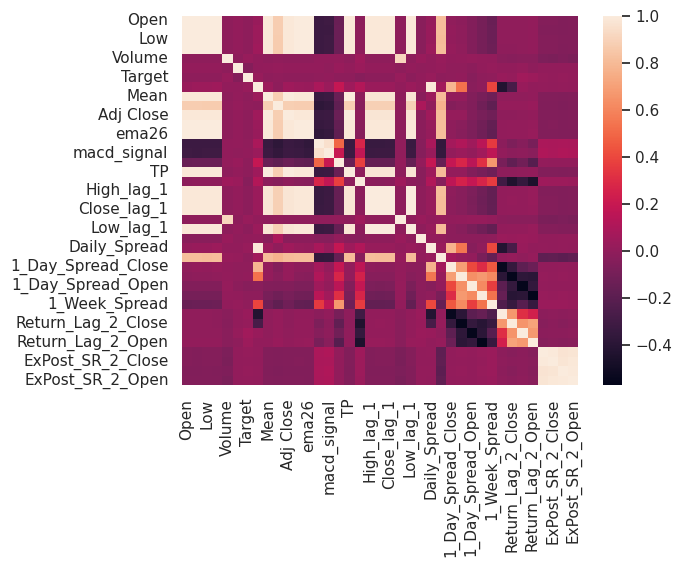

In [ ]:
sns.heatmap(df2.corr())

In [ ]:
# define our traing and test set
X = df2.drop( columns =[ 'Target','Open','High','Low','Close']).to_numpy()
y = df2['Target'].to_numpy()
X_train = df2_train.drop( columns =[ 'Target','Open','High','Low','Close']).to_numpy()
y_train = df2_train['Target'].to_numpy()
X_test = df2_test.drop( columns =[ 'Target','Open','High','Low','Close']).to_numpy()
y_test = df2_test['Target'].to_numpy()

# RFE : recursive feature elimination

In [ ]:
# function that takes in parameteres the traing and test set and returns the best features selected
def rfe_features(data, X_train, y_train, X_test, y_test,model):
  clf_rf_4 = model
  rfecv = RFECV(estimator=clf_rf_4, step=1, cv=4,scoring='r2')   #4-fold cross-validation (cv=4)
  rfecv = rfecv.fit(X_train, y_train)
  best_features= list(data.drop( columns =['Target','Open','High','Low','Close']).columns[rfecv.support_])
  return best_features

# Lower models

In [ ]:
# Dictionary to hold model names and results
model_results = {}

### OLS-KS (Ordinary Least Squares - Kitchen Sink)



In [ ]:
ols_ks_model = LinearRegression()
features_ols_ks = rfe_features(df2, X_train, y_train, X_test, y_test,ols_ks_model)
X_train_ols = df2_train[features_ols_ks]
X_test_ols = df2_test[features_ols_ks]

In [ ]:
ols_ks_model.fit(X_train_ols, y_train)
ols_ks_pred = ols_ks_model.predict(X_test_ols)


# Calculate metrics
r2 = r2_score(y_test, ols_ks_pred)
mse = mean_squared_error(y_test, ols_ks_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, ols_ks_pred)

# Store results in the model_results dictionary
model_results['OLS-KS'] = {'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae}

# Print the results using f-strings
print(f"OLS-KS R^2: {r2}")
print(f"OLS-KS MSE: {mse}")
print(f"OLS-KS RMSE: {rmse}")
print(f"OLS-KS MAE: {mae}")

OLS-KS R^2: -0.007149390241830256
OLS-KS MSE: 0.0017221771969053868
OLS-KS RMSE: 0.04149912284501188
OLS-KS MAE: 0.02752373747776079


### Huber Regressor


In [ ]:
# Define the model
huber_model = HuberRegressor()

# Feature selection (assuming you have an rfe_features function defined)
features_huber = rfe_features(df2, X_train, y_train, X_test, y_test, huber_model)

# Select the features for training and test sets
X_train_huber = df2_train[features_huber]
X_test_huber = df2_test[features_huber]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_

In [ ]:
# Fit the model
huber_model.fit(X_train_huber, y_train)
huber_pred = huber_model.predict(X_test_huber)

# Calculate metrics
r2_huber = r2_score(y_test, huber_pred)
mse_huber = mean_squared_error(y_test, huber_pred)
rmse_huber = sqrt(mse_huber)
mae_huber = mean_absolute_error(y_test, huber_pred)

# Store results in the model_results dictionary
model_results['Huber'] = {'R2': r2_huber, 'MSE': mse_huber, 'RMSE': rmse_huber, 'MAE': mae_huber}

# Print the results using f-strings
print(f"Huber R^2: {r2_huber}")
print(f"Huber MSE: {mse_huber}")
print(f"Huber RMSE: {rmse_huber}")
print(f"Huber MAE: {mae_huber}")

Huber R^2: -0.015837700787422193
Huber MSE: 0.0017370337916134055
Huber RMSE: 0.04167773736197067
Huber MAE: 0.027651818800541073


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### LASSO Regression



In [ ]:
lasso_model = Lasso()
features_lasso = rfe_features(df2, X_train, y_train, X_test, y_test,lasso_model)
X_train_lasso = df2_train[features_lasso]
X_test_lasso = df2_test[features_lasso]

In [ ]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_lasso, y_train)
lasso_pred = lasso_model.predict(X_test_lasso)

# Calculate metrics for LASSO
r2_lasso = r2_score(y_test, lasso_pred)
mse_lasso = mean_squared_error(y_test, lasso_pred)
rmse_lasso = sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y_test, lasso_pred)

# Store results in the model_results dictionary
model_results['LASSO'] = {'R2': r2_lasso, 'MSE': mse_lasso, 'RMSE': rmse_lasso, 'MAE': mae_lasso}

# Print the results using f-strings
print(f"LASSO R^2: {r2_lasso}")
print(f"LASSO MSE: {mse_lasso}")
print(f"LASSO RMSE: {rmse_lasso}")
print(f"LASSO MAE: {mae_lasso}")

LASSO R^2: -0.006511828521978513
LASSO MSE: 0.001721086996915011
LASSO RMSE: 0.04148598554831512
LASSO MAE: 0.027506758020137866


### CSR (Covariance-Shrinkage Regularization, approximated by Ridge Regression)



In [ ]:
csr_model = Ridge()
features_csr = rfe_features(df2, X_train, y_train, X_test, y_test,csr_model)
X_train_csr = df2_train[features_csr]
X_test_csr = df2_test[features_csr]

In [ ]:
csr_model = Ridge(alpha=1.0)
csr_model.fit(X_train_csr, y_train)
csr_pred = csr_model.predict(X_test_csr)

# Calculate metrics for CSR
r2_csr = r2_score(y_test, csr_pred)
mse_csr = mean_squared_error(y_test, csr_pred)
rmse_csr = sqrt(mse_csr)
mae_csr = mean_absolute_error(y_test, csr_pred)

# Store results in the model_results dictionary
model_results['CSR'] = {'R2': r2_csr, 'MSE': mse_csr, 'RMSE': rmse_csr, 'MAE': mae_csr}

# Print the results using f-strings
print(f"CSR R^2: {r2_csr}")
print(f"CSR MSE: {mse_csr}")
print(f"CSR RMSE: {rmse_csr}")
print(f"CSR MAE: {mae_csr}")


CSR R^2: -0.010676862562457812
CSR MSE: 0.001728209005544859
CSR RMSE: 0.04157173325163216
CSR MAE: 0.027572666548314913


### C-Enet (Combination Elastic Net)






In [ ]:
c_enet_model = ElasticNet()
features_cenet = rfe_features(df2, X_train, y_train, X_test, y_test,c_enet_model)
X_train_cenet = df2_train[features_cenet]
X_test_cenet = df2_test[features_cenet]

In [ ]:
c_enet_model = ElasticNet(alpha=0.1, l1_ratio=0.7)
c_enet_model.fit(X_train_cenet, y_train)
c_enet_pred = c_enet_model.predict(X_test_cenet)

# Calculate metrics for C-Enet
r2_c_enet = r2_score(y_test, c_enet_pred)
mse_c_enet = mean_squared_error(y_test, c_enet_pred)
rmse_c_enet = sqrt(mse_c_enet)
mae_c_enet = mean_absolute_error(y_test, c_enet_pred)

# Store results in the model_results dictionary
model_results['C-Enet'] = {'R2': r2_c_enet, 'MSE': mse_c_enet, 'RMSE': rmse_c_enet, 'MAE': mae_c_enet}

# Print the results using f-strings
print(f"C-Enet R^2: {r2_c_enet}")
print(f"C-Enet MSE: {mse_c_enet}")
print(f"C-Enet RMSE: {rmse_c_enet}")
print(f"C-Enet MAE: {mae_c_enet}")


C-Enet R^2: -0.006511828521978513
C-Enet MSE: 0.001721086996915011
C-Enet RMSE: 0.04148598554831512
C-Enet MAE: 0.027506758020137866


###  Principal Component Regression (PCR)


In [ ]:
# Principal Component Regression (PCR)
pca = PCA(n_components=5)  # Assuming we want to keep 5 components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pcr_model = LinearRegression()
pcr_model.fit(X_train_pca, y_train)
pcr_pred = pcr_model.predict(X_test_pca)

# Calculate metrics for PCR
r2_pcr = r2_score(y_test, pcr_pred)
mse_pcr = mean_squared_error(y_test, pcr_pred)
rmse_pcr = sqrt(mse_pcr)
mae_pcr = mean_absolute_error(y_test, pcr_pred)

# Store results in the model_results dictionary
model_results['PCR'] = {'R2': r2_pcr, 'MSE': mse_pcr, 'RMSE': rmse_pcr, 'MAE': mae_pcr}

# Print the results using f-strings
print(f"PCR R^2: {r2_pcr}")
print(f"PCR MSE: {mse_pcr}")
print(f"PCR RMSE: {rmse_pcr}")
print(f"PCR MAE: {mae_pcr}")

PCR R^2: -0.013374994844335575
PCR MSE: 0.0017328226824582394
PCR RMSE: 0.04162718681893168
PCR MAE: 0.02761322015615696


### Gradient Boosting Regression Tree (GBRT)



In [ ]:
gbrt_model = GradientBoostingRegressor()
features_gbrt = rfe_features(df2, X_train, y_train, X_test, y_test,gbrt_model)
X_train_gbrt = df2_train[features_gbrt]
X_test_gbrt = df2_test[features_gbrt]

In [ ]:
gbrt_model = GradientBoostingRegressor()
gbrt_model.fit(X_train_gbrt, y_train)
gbrt_pred = gbrt_model.predict(X_test_gbrt)

# Calculate metrics for GBRT
r2_gbrt = r2_score(y_test, gbrt_pred)
mse_gbrt = mean_squared_error(y_test, gbrt_pred)
rmse_gbrt = sqrt(mse_gbrt)
mae_gbrt = mean_absolute_error(y_test, gbrt_pred)

# Store results in the model_results dictionary
model_results['GBRT'] = {'R2': r2_gbrt, 'MSE': mse_gbrt, 'RMSE': rmse_gbrt, 'MAE': mae_gbrt}

# Print the results using f-strings
print(f"GBRT R^2: {r2_gbrt}")
print(f"GBRT MSE: {mse_gbrt}")
print(f"GBRT RMSE: {rmse_gbrt}")
print(f"GBRT MAE: {mae_gbrt}")


GBRT R^2: -0.7248332151430177
GBRT MSE: 0.002949382147638553
GBRT RMSE: 0.054308214366139425
GBRT MAE: 0.03811080088208632


### Random Forest (RF)

In [ ]:
rf_model = RandomForestRegressor()
features_rf = rfe_features(df2, X_train, y_train, X_test, y_test,rf_model)
X_train_rf = df2_train[features_rf]
X_test_rf = df2_test[features_rf]

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_rf, y_train)
rf_pred = rf_model.predict(X_test_rf)

# Calculate metrics for RF
r2_rf = r2_score(y_test, rf_pred)
mse_rf = mean_squared_error(y_test, rf_pred)
rmse_rf = sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, rf_pred)

# Store results in the model_results dictionary
model_results['RF'] = {'R2': r2_rf, 'MSE': mse_rf, 'RMSE': rmse_rf, 'MAE': mae_rf}

# Print the results using f-strings
print(f"RF R^2: {r2_rf}")
print(f"RF MSE: {mse_rf}")
print(f"RF RMSE: {rmse_rf}")
print(f"RF MAE: {mae_rf}")


RF R^2: -0.6861857240574725
RF MSE: 0.0028832967897859814
RF RMSE: 0.05369633870000804
RF MAE: 0.03860814022098926


### Neural Network (NN)

In [ ]:
nn_model = MLPRegressor(random_state=42)
nn_model.fit(X_train, y_train)
nn_pred = nn_model.predict(X_test)

# Calculate metrics for NN
r2_nn = r2_score(y_test, nn_pred)
mse_nn = mean_squared_error(y_test, nn_pred)
rmse_nn = sqrt(mse_nn)
mae_nn = mean_absolute_error(y_test, nn_pred)

# Store results in the model_results dictionary
model_results['NN'] = {'R2': r2_nn, 'MSE': mse_nn, 'RMSE': rmse_nn, 'MAE': mae_nn}

# Print the results using f-strings
print(f"NN R^2: {r2_nn}")
print(f"NN MSE: {mse_nn}")
print(f"NN RMSE: {rmse_nn}")
print(f"NN MAE: {mae_nn}")


NN R^2: -0.10357536945306434
NN MSE: 0.001887061000833408
NN RMSE: 0.04344031538597997
NN MAE: 0.029356633644287134


## comparing results

In [ ]:
# Create a DataFrame from the results
results_df = pd.DataFrame(model_results).T

# Print the results DataFrame
print(results_df)



              R2       MSE      RMSE       MAE
OLS-KS -0.007149  0.001722  0.041499  0.027524
Huber  -0.015838  0.001737  0.041678  0.027652
LASSO  -0.006512  0.001721  0.041486  0.027507
CSR    -0.010677  0.001728  0.041572  0.027573
C-Enet -0.006512  0.001721  0.041486  0.027507
PCR    -0.013375  0.001733  0.041627  0.027613
GBRT   -0.724833  0.002949  0.054308  0.038111
RF     -0.686186  0.002883  0.053696  0.038608
NN     -0.103575  0.001887  0.043440  0.029357
\begin{tabular}{lrrrr}
\toprule
{} &        R2 &       MSE &      RMSE &       MAE \\
\midrule
OLS-KS & -0.007149 &  0.001722 &  0.041499 &  0.027524 \\
Huber  & -0.015838 &  0.001737 &  0.041678 &  0.027652 \\
LASSO  & -0.006512 &  0.001721 &  0.041486 &  0.027507 \\
CSR    & -0.010677 &  0.001728 &  0.041572 &  0.027573 \\
C-Enet & -0.006512 &  0.001721 &  0.041486 &  0.027507 \\
PCR    & -0.013375 &  0.001733 &  0.041627 &  0.027613 \\
GBRT   & -0.724833 &  0.002949 &  0.054308 &  0.038111 \\
RF     & -0.686186 &  0.00288

<ipython-input-193-0440e295a699>:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.to_latex())


<ipython-input-190-908a1116118c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='R2', data=results_df, palette="viridis")


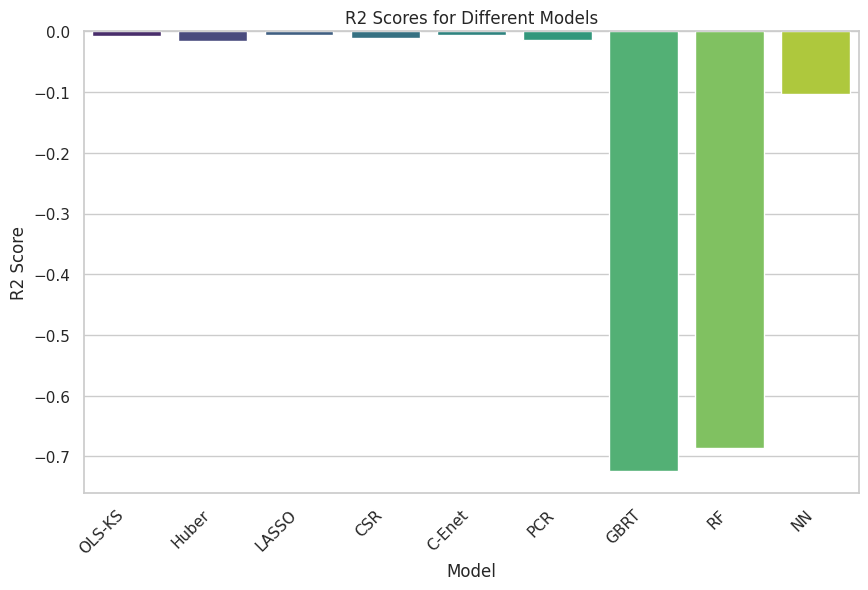

<ipython-input-190-908a1116118c>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='RMSE', data=results_df, palette="magma")


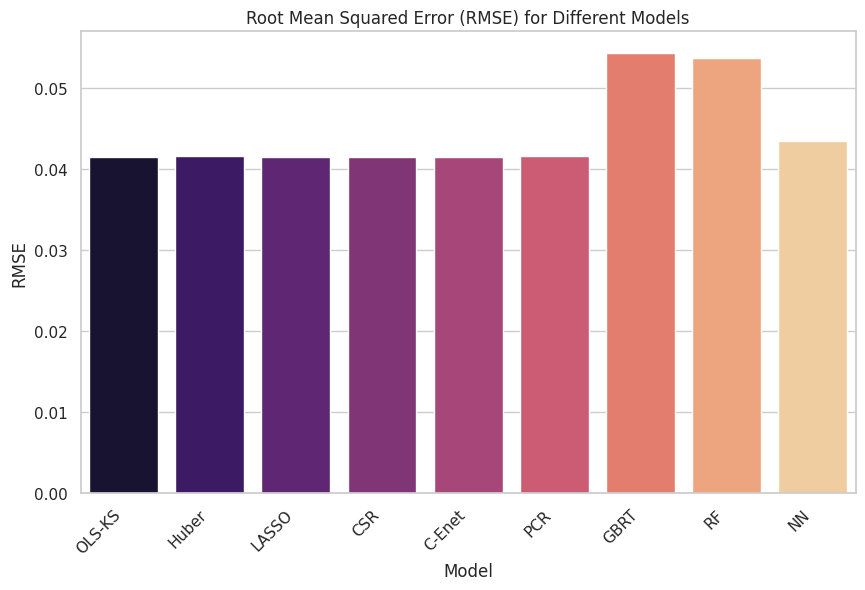

<ipython-input-190-908a1116118c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='MAE', data=results_df, palette="plasma")


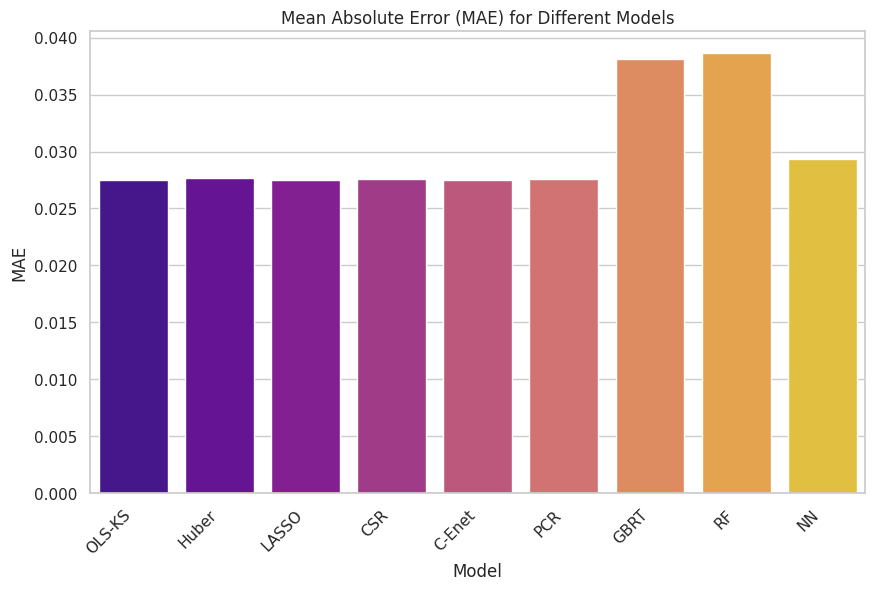

In [ ]:
# Set the style for Seaborn plots
sns.set(style="whitegrid")

# Bar plot for R2 scores
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='R2', data=results_df, palette="viridis")
plt.title('R2 Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.xticks(rotation=45, ha='right')
plt.show()

# Bar plot for RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='RMSE', data=results_df, palette="magma")
plt.title('Root Mean Squared Error (RMSE) for Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.show()

# Bar plot for MAE
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='MAE', data=results_df, palette="plasma")
plt.title('Mean Absolute Error (MAE) for Different Models')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')
plt.show()

# Stacking

In [ ]:
%%time

# Define base models
base_models = {
    'OLS-KS': LinearRegression(),
    'LASSO': Lasso(),
    'C-Enet': ElasticNet(alpha=0.1, l1_ratio=0.7),
    'huber' : HuberRegressor(),
    'CSR' : Ridge(alpha=1.0),
    'GBRT': GradientBoostingRegressor(),
    'RF': RandomForestRegressor(),
    'NN': MLPRegressor(random_state=42),
}

CPU times: user 246 µs, sys: 16 µs, total: 262 µs
Wall time: 271 µs


In [ ]:

#Define the list of features to include in the model
features=list(set( features_cenet + features_csr + features_lasso + features_ols_ks + features_gbrt + features_rf))
X_train = df2_train[features]
X_test = df2_test[features]

In [ ]:

# Train each base model and store predictions
base_model_predictions_train = {}
base_model_predictions_test = {}
for name, model in base_models.items():
    model.fit(X_train, y_train)
    base_model_predictions_train[name] = model.predict(X_train)
    base_model_predictions_test[name] = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Stacking with neural networks (St-NN)

#### two base model combination

In [ ]:
# Prepare a DataFrame to store the results
results_df_NN_2 = pd.DataFrame(columns=['Base Model 1', 'Base Model 2', 'R2', 'MSE', 'RMSE', 'MAE'])

# Generate all unique pairs of base models and compute metrics
for (model_name_1, model_1_preds), (model_name_2, model_2_preds) in combinations(base_model_predictions_train.items(), 2):
    # Stack the predictions of the base models for training the meta-model
    X_meta_train = np.column_stack((model_1_preds, model_2_preds))
    X_meta_test = np.column_stack((base_model_predictions_test[model_name_1], base_model_predictions_test[model_name_2]))

    # Train the NN meta-model on stacked predictions
    nn_meta_model = MLPRegressor(random_state=42).fit(X_meta_train, y_train)

    # Predict using the meta-model
    nn_meta_predictions = nn_meta_model.predict(X_meta_test)

    # Calculate metrics
    r2 = r2_score(y_test, nn_meta_predictions)
    mse = mean_squared_error(y_test, nn_meta_predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, nn_meta_predictions)

    # Store the results
    results_df_NN_2 = results_df_NN_2.append({
        'Base Model 1': model_name_1,
        'Base Model 2': model_name_2,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }, ignore_index=True)

# Display the results
print(results_df_NN_2)

<ipython-input-197-1a7b68ebe96f>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_2 = results_df_NN_2.append({
<ipython-input-197-1a7b68ebe96f>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_2 = results_df_NN_2.append({
<ipython-input-197-1a7b68ebe96f>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_2 = results_df_NN_2.append({
<ipython-input-197-1a7b68ebe96f>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_2 = results_df_NN_2.append({
<ipython-input-197-1a7b68ebe96f>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

   Base Model 1 Base Model 2        R2       MSE      RMSE       MAE
0        OLS-KS        LASSO -0.006866  0.001722  0.041493  0.027528
1        OLS-KS       C-Enet -0.006866  0.001722  0.041493  0.027528
2        OLS-KS        huber -0.007006  0.001722  0.041496  0.027535
3        OLS-KS          CSR -0.006956  0.001722  0.041495  0.027535
4        OLS-KS         GBRT -1.432055  0.004159  0.064488  0.048148
5        OLS-KS           RF -1.187586  0.003741  0.061161  0.045534
6        OLS-KS           NN -0.006866  0.001722  0.041493  0.027544
7         LASSO       C-Enet -0.006019  0.001720  0.041476  0.027497
8         LASSO        huber -0.005928  0.001720  0.041474  0.027499
9         LASSO          CSR -0.005893  0.001720  0.041473  0.027499
10        LASSO         GBRT -1.133011  0.003647  0.060393  0.044232
11        LASSO           RF -1.179944  0.003728  0.061054  0.045420
12        LASSO           NN -0.005922  0.001720  0.041474  0.027512
13       C-Enet        huber -0.00

<ipython-input-197-1a7b68ebe96f>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_2 = results_df_NN_2.append({


In [ ]:
# Find the index of the best combinations for each metric
best_r2_index = results_df_NN_2['R2'].idxmax()
best_mse_index = results_df_NN_2['MSE'].idxmin()
best_rmse_index = results_df_NN_2['RMSE'].idxmin()
best_mae_index = results_df_NN_2['MAE'].idxmin()

# Extract the names and values of the best combinations
best_r2_combination = results_df_NN_2.loc[best_r2_index]
best_mse_combination = results_df_NN_2.loc[best_mse_index]
best_rmse_combination = results_df_NN_2.loc[best_rmse_index]
best_mae_combination = results_df_NN_2.loc[best_mae_index]

# Creating a new DataFrame to store the best combinations along with their metric values
best_combinations_df = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE', 'MAE'],
    'Base Model 1': [
        best_r2_combination['Base Model 1'],
        best_mse_combination['Base Model 1'],
        best_rmse_combination['Base Model 1'],
        best_mae_combination['Base Model 1']
    ],
    'Base Model 2': [
        best_r2_combination['Base Model 2'],
        best_mse_combination['Base Model 2'],
        best_rmse_combination['Base Model 2'],
        best_mae_combination['Base Model 2']
    ],
    'Value': [
        best_r2_combination['R2'],
        best_mse_combination['MSE'],
        best_rmse_combination['RMSE'],
        best_mae_combination['MAE']
    ]
})

# Display the DataFrame
print(best_combinations_df)


  Metric Base Model 1 Base Model 2     Value
0     R2          CSR           NN -0.005754
1    MSE          CSR           NN  0.001720
2   RMSE          CSR           NN  0.041470
3    MAE        LASSO       C-Enet  0.027497


#### 3 base model combination

In [ ]:
# Prepare a DataFrame to store the results
results_df_NN_3 = pd.DataFrame(columns=['Base Model 1', 'Base Model 2', 'Base Model 3', 'R2', 'MSE', 'RMSE', 'MAE'])

# Generate all unique triplets of base models and compute metrics
for (model_name_1, model_1_preds), (model_name_2, model_2_preds), (model_name_3, model_3_preds) in combinations(base_model_predictions_train.items(), 3):
    # Stack the predictions of the base models for training the meta-model
    X_meta_train = np.column_stack((model_1_preds, model_2_preds, base_model_predictions_train[model_name_3]))
    X_meta_test = np.column_stack((base_model_predictions_test[model_name_1], base_model_predictions_test[model_name_2], base_model_predictions_test[model_name_3]))

    # Train the NN meta-model on stacked predictions
    nn_meta_model = MLPRegressor(random_state=42).fit(X_meta_train, y_train)

    # Predict using the meta-model
    nn_meta_predictions = nn_meta_model.predict(X_meta_test)

    # Calculate metrics
    r2 = r2_score(y_test, nn_meta_predictions)
    mse = mean_squared_error(y_test, nn_meta_predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, nn_meta_predictions)

    # Store the results
    results_df_NN_3 = results_df_NN_3.append({
        'Base Model 1': model_name_1,
        'Base Model 2': model_name_2,
        'Base Model 3': model_name_3,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }, ignore_index=True)

# Display the results
print(results_df_NN_3)

<ipython-input-201-54ecca6097eb>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_3 = results_df_NN_3.append({
<ipython-input-201-54ecca6097eb>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_3 = results_df_NN_3.append({
<ipython-input-201-54ecca6097eb>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_3 = results_df_NN_3.append({
<ipython-input-201-54ecca6097eb>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_3 = results_df_NN_3.append({
<ipython-input-201-54ecca6097eb>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

   Base Model 1 Base Model 2 Base Model 3        R2       MSE      RMSE  \
0        OLS-KS        LASSO       C-Enet -0.002383  0.001714  0.041401   
1        OLS-KS        LASSO        huber -0.004450  0.001718  0.041443   
2        OLS-KS        LASSO          CSR -0.004175  0.001717  0.041438   
3        OLS-KS        LASSO         GBRT -0.702439  0.002911  0.053955   
4        OLS-KS        LASSO           RF -1.156580  0.003688  0.060726   
5        OLS-KS        LASSO           NN -0.004420  0.001718  0.041443   
6        OLS-KS       C-Enet        huber -0.004450  0.001718  0.041443   
7        OLS-KS       C-Enet          CSR -0.004175  0.001717  0.041438   
8        OLS-KS       C-Enet         GBRT -0.702439  0.002911  0.053955   
9        OLS-KS       C-Enet           RF -1.156580  0.003688  0.060726   
10       OLS-KS       C-Enet           NN -0.004420  0.001718  0.041443   
11       OLS-KS        huber          CSR -0.007200  0.001722  0.041500   
12       OLS-KS        hu

<ipython-input-201-54ecca6097eb>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_3 = results_df_NN_3.append({


In [ ]:
# Find the index of the best combinations for each metric
best_r2_index = results_df_NN_3['R2'].idxmax()
best_mse_index = results_df_NN_3['MSE'].idxmin()
best_rmse_index = results_df_NN_3['RMSE'].idxmin()
best_mae_index = results_df_NN_3['MAE'].idxmin()

# Extract the names and values of the best combinations
best_combinations_df = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE', 'MAE'],
    'Base Model 1': [
        results_df_NN_3.loc[best_r2_index, 'Base Model 1'],
        results_df_NN_3.loc[best_mse_index, 'Base Model 1'],
        results_df_NN_3.loc[best_rmse_index, 'Base Model 1'],
        results_df_NN_3.loc[best_mae_index, 'Base Model 1']
    ],
    'Base Model 2': [
        results_df_NN_3.loc[best_r2_index, 'Base Model 2'],
        results_df_NN_3.loc[best_mse_index, 'Base Model 2'],
        results_df_NN_3.loc[best_rmse_index, 'Base Model 2'],
        results_df_NN_3.loc[best_mae_index, 'Base Model 2']
    ],
    'Base Model 3': [
        results_df_NN_3.loc[best_r2_index, 'Base Model 3'],
        results_df_NN_3.loc[best_mse_index, 'Base Model 3'],
        results_df_NN_3.loc[best_rmse_index, 'Base Model 3'],
        results_df_NN_3.loc[best_mae_index, 'Base Model 3']
    ],
    'Value': [
        results_df_NN_3.loc[best_r2_index, 'R2'],
        results_df_NN_3.loc[best_mse_index, 'MSE'],
        results_df_NN_3.loc[best_rmse_index, 'RMSE'],
        results_df_NN_3.loc[best_mae_index, 'MAE']
    ]
})

# Display the DataFrame
print(best_combinations_df)

  Metric Base Model 1 Base Model 2 Base Model 3     Value
0     R2       OLS-KS        LASSO       C-Enet -0.002383
1    MSE       OLS-KS        LASSO       C-Enet  0.001714
2   RMSE       OLS-KS        LASSO       C-Enet  0.041401
3    MAE        LASSO       C-Enet          CSR  0.027430


#### 4 base model combination

In [ ]:
# Prepare a DataFrame to store the results
results_df_NN_4 = pd.DataFrame(columns=['Base Model 1', 'Base Model 2', 'Base Model 3', 'Base Model 4', 'R2', 'MSE', 'RMSE', 'MAE'])

# Generate all unique quartets of base models and compute metrics
for (model_name_1, model_1_preds), (model_name_2, model_2_preds), (model_name_3, model_3_preds), (model_name_4, model_4_preds) in combinations(base_model_predictions_train.items(), 4):
    # Stack the predictions of the base models for training the meta-model
    X_meta_train = np.column_stack((model_1_preds, model_2_preds, model_3_preds, base_model_predictions_train[model_name_4]))
    X_meta_test = np.column_stack((base_model_predictions_test[model_name_1], base_model_predictions_test[model_name_2], base_model_predictions_test[model_name_3], base_model_predictions_test[model_name_4]))

    # Train the NN meta-model on stacked predictions
    nn_meta_model = MLPRegressor(random_state=42).fit(X_meta_train, y_train)

    # Predict using the meta-model
    nn_meta_predictions = nn_meta_model.predict(X_meta_test)

    # Calculate metrics
    r2 = r2_score(y_test, nn_meta_predictions)
    mse = mean_squared_error(y_test, nn_meta_predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, nn_meta_predictions)

    # Store the results
    results_df_NN_4 = results_df_NN_4.append({
        'Base Model 1': model_name_1,
        'Base Model 2': model_name_2,
        'Base Model 3': model_name_3,
        'Base Model 4': model_name_4,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }, ignore_index=True)

# Display the results
print(results_df_NN_4)

<ipython-input-203-6f0a7fdbb0e4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_4 = results_df_NN_4.append({
<ipython-input-203-6f0a7fdbb0e4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_4 = results_df_NN_4.append({
<ipython-input-203-6f0a7fdbb0e4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_4 = results_df_NN_4.append({
<ipython-input-203-6f0a7fdbb0e4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_4 = results_df_NN_4.append({
<ipython-input-203-6f0a7fdbb0e4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

   Base Model 1 Base Model 2 Base Model 3 Base Model 4        R2       MSE  \
0        OLS-KS        LASSO       C-Enet        huber -0.015868  0.001737   
1        OLS-KS        LASSO       C-Enet          CSR -0.015508  0.001736   
2        OLS-KS        LASSO       C-Enet         GBRT -0.704270  0.002914   
3        OLS-KS        LASSO       C-Enet           RF -1.174080  0.003718   
4        OLS-KS        LASSO       C-Enet           NN -0.017478  0.001740   
..          ...          ...          ...          ...       ...       ...   
65        huber          CSR         GBRT           RF -1.155648  0.003686   
66        huber          CSR         GBRT           NN -1.552873  0.004365   
67        huber          CSR           RF           NN -1.231606  0.003816   
68        huber         GBRT           RF           NN -1.079083  0.003555   
69          CSR         GBRT           RF           NN -1.075746  0.003549   

        RMSE       MAE  
0   0.041678  0.027710  
1   0.041671 

<ipython-input-203-6f0a7fdbb0e4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_NN_4 = results_df_NN_4.append({


In [ ]:
# Find the index of the best combinations for each metric
best_r2_index = results_df_NN_4['R2'].idxmax()
best_mse_index = results_df_NN_4['MSE'].idxmin()
best_rmse_index = results_df_NN_4['RMSE'].idxmin()
best_mae_index = results_df_NN_4['MAE'].idxmin()

# Extract the names and values of the best combinations
best_combinations_df = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE', 'MAE'],
    'Base Model 1': [
        results_df_NN_4.loc[best_r2_index, 'Base Model 1'],
        results_df_NN_4.loc[best_mse_index, 'Base Model 1'],
        results_df_NN_4.loc[best_rmse_index, 'Base Model 1'],
        results_df_NN_4.loc[best_mae_index, 'Base Model 1']
    ],
    'Base Model 2': [
        results_df_NN_4.loc[best_r2_index, 'Base Model 2'],
        results_df_NN_4.loc[best_mse_index, 'Base Model 2'],
        results_df_NN_4.loc[best_rmse_index, 'Base Model 2'],
        results_df_NN_4.loc[best_mae_index, 'Base Model 2']
    ],
    'Base Model 3': [
        results_df_NN_4.loc[best_r2_index, 'Base Model 3'],
        results_df_NN_4.loc[best_mse_index, 'Base Model 3'],
        results_df_NN_4.loc[best_rmse_index, 'Base Model 3'],
        results_df_NN_4.loc[best_mae_index, 'Base Model 3']
    ],
    'Base Model 4': [
        results_df_NN_4.loc[best_r2_index, 'Base Model 4'],
        results_df_NN_4.loc[best_mse_index, 'Base Model 4'],
        results_df_NN_4.loc[best_rmse_index, 'Base Model 4'],
        results_df_NN_4.loc[best_mae_index, 'Base Model 4']
    ],
    'Value': [
        results_df_NN_4.loc[best_r2_index, 'R2'],
        results_df_NN_4.loc[best_mse_index, 'MSE'],
        results_df_NN_4.loc[best_rmse_index, 'RMSE'],
        results_df_NN_4.loc[best_mae_index, 'MAE']
    ]
})

# Display the DataFrame
print(best_combinations_df)

  Metric Base Model 1 Base Model 2 Base Model 3 Base Model 4     Value
0     R2       OLS-KS        LASSO       C-Enet          CSR -0.015508
1    MSE       OLS-KS        LASSO       C-Enet          CSR  0.001736
2   RMSE       OLS-KS        LASSO       C-Enet          CSR  0.041671
3    MAE       OLS-KS        LASSO       C-Enet        huber  0.027710


### Stacking with random forest (St-RF)

#### two base model combination




In [ ]:
# Prepare a DataFrame to store the results
rf_results_df_RF_2 = pd.DataFrame(columns=['Base Model 1', 'Base Model 2', 'R2', 'MSE', 'RMSE', 'MAE'])

# Generate all unique pairs of base models and compute metrics
for (model_name_1, model_1_preds), (model_name_2, model_2_preds) in combinations(base_model_predictions_train.items(), 2):
    # Stack the predictions of the base models for training the meta-model
    X_meta_train = np.column_stack((model_1_preds, model_2_preds))
    X_meta_test = np.column_stack((base_model_predictions_test[model_name_1], base_model_predictions_test[model_name_2]))

    # Train the Random Forest meta-model on stacked predictions
    rf_meta_model = RandomForestRegressor().fit(X_meta_train, y_train)

    # Predict using the meta-model
    rf_meta_predictions = rf_meta_model.predict(X_meta_test)

    # Calculate metrics
    r2 = r2_score(y_test, rf_meta_predictions)
    mse = mean_squared_error(y_test, rf_meta_predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, rf_meta_predictions)

    # Store the results
    rf_results_df_RF_2 = rf_results_df_RF_2.append({
        'Base Model 1': model_name_1,
        'Base Model 2': model_name_2,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }, ignore_index=True)

# Display the results
print(rf_results_df_RF_2)

<ipython-input-207-a2d76a9f595b>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_2 = rf_results_df_RF_2.append({
<ipython-input-207-a2d76a9f595b>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_2 = rf_results_df_RF_2.append({
<ipython-input-207-a2d76a9f595b>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_2 = rf_results_df_RF_2.append({
<ipython-input-207-a2d76a9f595b>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_2 = rf_results_df_RF_2.append({
<ipython-input-207-a2d76a9f595b>:23: FutureWarning: The frame.append method is deprecated and will be removed from p

   Base Model 1 Base Model 2        R2       MSE      RMSE       MAE
0        OLS-KS        LASSO -0.542835  0.002638  0.051363  0.036324
1        OLS-KS       C-Enet -0.547962  0.002647  0.051448  0.036394
2        OLS-KS        huber -0.191159  0.002037  0.045131  0.031067
3        OLS-KS          CSR -0.194265  0.002042  0.045190  0.031465
4        OLS-KS         GBRT -2.784566  0.006471  0.080445  0.060529
5        OLS-KS           RF -1.175293  0.003720  0.060989  0.045493
6        OLS-KS           NN -0.186314  0.002029  0.045039  0.031313
7         LASSO       C-Enet -0.006390  0.001721  0.041483  0.027504
8         LASSO        huber -0.489948  0.002548  0.050475  0.035858
9         LASSO          CSR -0.469866  0.002513  0.050134  0.035783
10        LASSO         GBRT -3.143883  0.007086  0.084177  0.063416
11        LASSO           RF -1.184764  0.003736  0.061122  0.045417
12        LASSO           NN -0.390895  0.002378  0.048768  0.035267
13       C-Enet        huber -0.48

<ipython-input-207-a2d76a9f595b>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_2 = rf_results_df_RF_2.append({


In [ ]:
# Find the index of the best combinations for each metric
best_r2_index = rf_results_df_RF_2['R2'].idxmax()
best_mse_index = rf_results_df_RF_2['MSE'].idxmin()
best_rmse_index = rf_results_df_RF_2['RMSE'].idxmin()
best_mae_index = rf_results_df_RF_2['MAE'].idxmin()

# Extract the names and values of the best combinations
best_combinations_df = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE', 'MAE'],
    'Base Model 1': [
        rf_results_df_RF_2.loc[best_r2_index, 'Base Model 1'],
        rf_results_df_RF_2.loc[best_mse_index, 'Base Model 1'],
        rf_results_df_RF_2.loc[best_rmse_index, 'Base Model 1'],
        rf_results_df_RF_2.loc[best_mae_index, 'Base Model 1']
    ],
    'Base Model 2': [
        rf_results_df_RF_2.loc[best_r2_index, 'Base Model 2'],
        rf_results_df_RF_2.loc[best_mse_index, 'Base Model 2'],
        rf_results_df_RF_2.loc[best_rmse_index, 'Base Model 2'],
        rf_results_df_RF_2.loc[best_mae_index, 'Base Model 2']
    ],
    'Value': [
        rf_results_df_RF_2.loc[best_r2_index, 'R2'],
        rf_results_df_RF_2.loc[best_mse_index, 'MSE'],
        rf_results_df_RF_2.loc[best_rmse_index, 'RMSE'],
        rf_results_df_RF_2.loc[best_mae_index, 'MAE']
    ]
})

# Print the DataFrame to display the results
print(best_combinations_df)

  Metric Base Model 1 Base Model 2     Value
0     R2        LASSO       C-Enet -0.006390
1    MSE        LASSO       C-Enet  0.001721
2   RMSE        LASSO       C-Enet  0.041483
3    MAE        LASSO       C-Enet  0.027504


#### 3 base model combination


In [ ]:
# Prepare a DataFrame to store the results
rf_results_df_RF_3 = pd.DataFrame(columns=['Base Model 1', 'Base Model 2', 'Base Model 3', 'R2', 'MSE', 'RMSE', 'MAE'])

# Generate all unique triplets of base models and compute metrics
for (model_name_1, model_1_preds), (model_name_2, model_2_preds), (model_name_3, model_3_preds) in combinations(base_model_predictions_train.items(), 3):
    # Stack the predictions of the base models for training the meta-model
    X_meta_train = np.column_stack((model_1_preds, model_2_preds, base_model_predictions_train[model_name_3]))
    X_meta_test = np.column_stack((base_model_predictions_test[model_name_1], base_model_predictions_test[model_name_2], base_model_predictions_test[model_name_3]))

    # Train the Random Forest meta-model on stacked predictions
    rf_meta_model = RandomForestRegressor().fit(X_meta_train, y_train)

    # Predict using the meta-model
    rf_meta_predictions = rf_meta_model.predict(X_meta_test)

    # Calculate metrics
    r2 = r2_score(y_test, rf_meta_predictions)
    mse = mean_squared_error(y_test, rf_meta_predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, rf_meta_predictions)

    # Store the results
    rf_results_df_RF_3 = rf_results_df_RF_3.append({
        'Base Model 1': model_name_1,
        'Base Model 2': model_name_2,
        'Base Model 3': model_name_3,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }, ignore_index=True)

# Display the results
print(rf_results_df_RF_3)

<ipython-input-209-3a47c540bbd2>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_3 = rf_results_df_RF_3.append({
<ipython-input-209-3a47c540bbd2>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_3 = rf_results_df_RF_3.append({
<ipython-input-209-3a47c540bbd2>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_3 = rf_results_df_RF_3.append({
<ipython-input-209-3a47c540bbd2>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_3 = rf_results_df_RF_3.append({
<ipython-input-209-3a47c540bbd2>:23: FutureWarning: The frame.append method is deprecated and will be removed from p

   Base Model 1 Base Model 2 Base Model 3        R2       MSE      RMSE  \
0        OLS-KS        LASSO       C-Enet -0.544097  0.002640  0.051384   
1        OLS-KS        LASSO        huber -0.198152  0.002049  0.045263   
2        OLS-KS        LASSO          CSR -0.194177  0.002042  0.045188   
3        OLS-KS        LASSO         GBRT -2.784199  0.006471  0.080441   
4        OLS-KS        LASSO           RF -1.173838  0.003717  0.060969   
5        OLS-KS        LASSO           NN -0.201697  0.002055  0.045330   
6        OLS-KS       C-Enet        huber -0.198461  0.002049  0.045269   
7        OLS-KS       C-Enet          CSR -0.202969  0.002057  0.045354   
8        OLS-KS       C-Enet         GBRT -2.791479  0.006483  0.080519   
9        OLS-KS       C-Enet           RF -1.171767  0.003714  0.060939   
10       OLS-KS       C-Enet           NN -0.195536  0.002044  0.045214   
11       OLS-KS        huber          CSR -0.139248  0.001948  0.044137   
12       OLS-KS        hu

<ipython-input-209-3a47c540bbd2>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_3 = rf_results_df_RF_3.append({


In [ ]:
# Find the index of the best combinations for each metric
best_r2_index = rf_results_df_RF_3['R2'].idxmax()
best_mse_index = rf_results_df_RF_3['MSE'].idxmin()
best_rmse_index = rf_results_df_RF_3['RMSE'].idxmin()
best_mae_index = rf_results_df_RF_3['MAE'].idxmin()

# Extract the names and values of the best combinations
best_combinations_df = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE', 'MAE'],
    'Base Model 1': [
        rf_results_df_RF_3.loc[best_r2_index, 'Base Model 1'],
        rf_results_df_RF_3.loc[best_mse_index, 'Base Model 1'],
        rf_results_df_RF_3.loc[best_rmse_index, 'Base Model 1'],
        rf_results_df_RF_3.loc[best_mae_index, 'Base Model 1']
    ],
    'Base Model 2': [
        rf_results_df_RF_3.loc[best_r2_index, 'Base Model 2'],
        rf_results_df_RF_3.loc[best_mse_index, 'Base Model 2'],
        rf_results_df_RF_3.loc[best_rmse_index, 'Base Model 2'],
        rf_results_df_RF_3.loc[best_mae_index, 'Base Model 2']
    ],
    'Base Model 3': [
        rf_results_df_RF_3.loc[best_r2_index, 'Base Model 3'],
        rf_results_df_RF_3.loc[best_mse_index, 'Base Model 3'],
        rf_results_df_RF_3.loc[best_rmse_index, 'Base Model 3'],
        rf_results_df_RF_3.loc[best_mae_index, 'Base Model 3']
    ],
    'Value': [
        rf_results_df_RF_3.loc[best_r2_index, 'R2'],
        rf_results_df_RF_3.loc[best_mse_index, 'MSE'],
        rf_results_df_RF_3.loc[best_rmse_index, 'RMSE'],
        rf_results_df_RF_3.loc[best_mae_index, 'MAE']
    ]
})

# Display the DataFrame
print(best_combinations_df)

  Metric Base Model 1 Base Model 2 Base Model 3     Value
0     R2        huber          CSR           NN -0.118247
1    MSE        huber          CSR           NN  0.001912
2   RMSE        huber          CSR           NN  0.043728
3    MAE        huber          CSR           NN  0.029859


#### 4 base model combination


In [ ]:
# Prepare a DataFrame to store the results
rf_results_df_RF_4 = pd.DataFrame(columns=['Base Model 1', 'Base Model 2', 'Base Model 3', 'Base Model 4', 'R2', 'MSE', 'RMSE', 'MAE'])

# Generate all unique quartets of base models and compute metrics
for (model_name_1, model_1_preds), (model_name_2, model_2_preds), (model_name_3, model_3_preds), (model_name_4, model_4_preds) in combinations(base_model_predictions_train.items(), 4):
    # Stack the predictions of the base models for training the meta-model
    X_meta_train = np.column_stack((model_1_preds, model_2_preds, model_3_preds, model_4_preds))
    X_meta_test = np.column_stack((base_model_predictions_test[model_name_1], base_model_predictions_test[model_name_2], base_model_predictions_test[model_name_3], base_model_predictions_test[model_name_4]))

    # Train the Random Forest meta-model on stacked predictions
    rf_meta_model = RandomForestRegressor().fit(X_meta_train, y_train)

    # Predict using the meta-model
    rf_meta_predictions = rf_meta_model.predict(X_meta_test)

    # Calculate metrics
    r2 = r2_score(y_test, rf_meta_predictions)
    mse = mean_squared_error(y_test, rf_meta_predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, rf_meta_predictions)

    # Store the results
    rf_results_df_RF_4 = rf_results_df_RF_4.append({
        'Base Model 1': model_name_1,
        'Base Model 2': model_name_2,
        'Base Model 3': model_name_3,
        'Base Model 4': model_name_4,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }, ignore_index=True)

# Display the results
print(rf_results_df_RF_4)

<ipython-input-211-e258798bef38>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_4 = rf_results_df_RF_4.append({
<ipython-input-211-e258798bef38>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_4 = rf_results_df_RF_4.append({
<ipython-input-211-e258798bef38>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_4 = rf_results_df_RF_4.append({
<ipython-input-211-e258798bef38>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_4 = rf_results_df_RF_4.append({
<ipython-input-211-e258798bef38>:23: FutureWarning: The frame.append method is deprecated and will be removed from p

   Base Model 1 Base Model 2 Base Model 3 Base Model 4        R2       MSE  \
0        OLS-KS        LASSO       C-Enet        huber -0.193839  0.002041   
1        OLS-KS        LASSO       C-Enet          CSR -0.196612  0.002046   
2        OLS-KS        LASSO       C-Enet         GBRT -2.863853  0.006607   
3        OLS-KS        LASSO       C-Enet           RF -1.172074  0.003714   
4        OLS-KS        LASSO       C-Enet           NN -0.196204  0.002045   
..          ...          ...          ...          ...       ...       ...   
65        huber          CSR         GBRT           RF -0.901763  0.003252   
66        huber          CSR         GBRT           NN -2.374017  0.005769   
67        huber          CSR           RF           NN -1.177273  0.003723   
68        huber         GBRT           RF           NN -0.889362  0.003231   
69          CSR         GBRT           RF           NN -0.903881  0.003256   

        RMSE       MAE  
0   0.045182  0.031184  
1   0.045234 

<ipython-input-211-e258798bef38>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rf_results_df_RF_4 = rf_results_df_RF_4.append({


In [ ]:
# Find the index of the best combinations for each metric
best_r2_index = rf_results_df_RF_4['R2'].idxmax()
best_mse_index = rf_results_df_RF_4['MSE'].idxmin()
best_rmse_index = rf_results_df_RF_4['RMSE'].idxmin()
best_mae_index = rf_results_df_RF_4['MAE'].idxmin()

# Extract the names and values of the best combinations
best_combinations_df = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE', 'MAE'],
    'Base Model 1': [
        rf_results_df_RF_4.loc[best_r2_index, 'Base Model 1'],
        rf_results_df_RF_4.loc[best_mse_index, 'Base Model 1'],
        rf_results_df_RF_4.loc[best_rmse_index, 'Base Model 1'],
        rf_results_df_RF_4.loc[best_mae_index, 'Base Model 1']
    ],
    'Base Model 2': [
        rf_results_df_RF_4.loc[best_r2_index, 'Base Model 2'],
        rf_results_df_RF_4.loc[best_mse_index, 'Base Model 2'],
        rf_results_df_RF_4.loc[best_rmse_index, 'Base Model 2'],
        rf_results_df_RF_4.loc[best_mae_index, 'Base Model 2']
    ],
    'Base Model 3': [
        rf_results_df_RF_4.loc[best_r2_index, 'Base Model 3'],
        rf_results_df_RF_4.loc[best_mse_index, 'Base Model 3'],
        rf_results_df_RF_4.loc[best_rmse_index, 'Base Model 3'],
        rf_results_df_RF_4.loc[best_mae_index, 'Base Model 3']
    ],
    'Base Model 4': [
        rf_results_df_RF_4.loc[best_r2_index, 'Base Model 4'],
        rf_results_df_RF_4.loc[best_mse_index, 'Base Model 4'],
        rf_results_df_RF_4.loc[best_rmse_index, 'Base Model 4'],
        rf_results_df_RF_4.loc[best_mae_index, 'Base Model 4']
    ],
    'Value': [
        rf_results_df_RF_4.loc[best_r2_index, 'R2'],
        rf_results_df_RF_4.loc[best_mse_index, 'MSE'],
        rf_results_df_RF_4.loc[best_rmse_index, 'RMSE'],
        rf_results_df_RF_4.loc[best_mae_index, 'MAE']
    ]
})

# Display the DataFrame
print(best_combinations_df)

  Metric Base Model 1 Base Model 2 Base Model 3 Base Model 4     Value
0     R2       OLS-KS        huber          CSR           NN -0.119779
1    MSE       OLS-KS        huber          CSR           NN  0.001915
2   RMSE       OLS-KS        huber          CSR           NN  0.043758
3    MAE       OLS-KS        huber          CSR           NN  0.029760


### stacking with gradient boosted regression trees (St-GBRT)

#### two base model combination


In [ ]:
# Prepare a DataFrame to store the results
gbrt_results_df_GBRT_2 = pd.DataFrame(columns=['Base Model 1', 'Base Model 2', 'R2', 'MSE', 'RMSE', 'MAE'])

# Generate all unique pairs of base models and compute metrics
for (model_name_1, model_1_preds), (model_name_2, model_2_preds) in combinations(base_model_predictions_train.items(), 2):
    # Stack the predictions of the base models for training the meta-model
    X_meta_train = np.column_stack((model_1_preds, model_2_preds))
    X_meta_test = np.column_stack((base_model_predictions_test[model_name_1], base_model_predictions_test[model_name_2]))

    # Train the GBRT meta-model on stacked predictions
    gbrt_meta_model = GradientBoostingRegressor().fit(X_meta_train, y_train)

    # Predict using the meta-model
    gbrt_meta_predictions = gbrt_meta_model.predict(X_meta_test)

    # Calculate metrics
    r2 = r2_score(y_test, gbrt_meta_predictions)
    mse = mean_squared_error(y_test, gbrt_meta_predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, gbrt_meta_predictions)

    # Store the results
    gbrt_results_df_GBRT_2 = gbrt_results_df_GBRT_2.append({
        'Base Model 1': model_name_1,
        'Base Model 2': model_name_2,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }, ignore_index=True)

# Display the results
print(gbrt_results_df_GBRT_2)

<ipython-input-213-07cdf07eb28c>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_2 = gbrt_results_df_GBRT_2.append({
<ipython-input-213-07cdf07eb28c>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_2 = gbrt_results_df_GBRT_2.append({
<ipython-input-213-07cdf07eb28c>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_2 = gbrt_results_df_GBRT_2.append({
<ipython-input-213-07cdf07eb28c>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_2 = gbrt_results_df_GBRT_2.append({
<ipython-input-213-07cdf07eb28c>:23: FutureWarning: The frame.append method is depre

   Base Model 1 Base Model 2        R2       MSE      RMSE       MAE
0        OLS-KS        LASSO -0.039389  0.001777  0.042158  0.028104
1        OLS-KS       C-Enet -0.039389  0.001777  0.042158  0.028104
2        OLS-KS        huber -0.032814  0.001766  0.042025  0.028075
3        OLS-KS          CSR -0.040122  0.001779  0.042173  0.028087
4        OLS-KS         GBRT -2.528286  0.006033  0.077674  0.059242
5        OLS-KS           RF -1.160320  0.003694  0.060779  0.045218
6        OLS-KS           NN -0.039637  0.001778  0.042163  0.028112
7         LASSO       C-Enet -0.006512  0.001721  0.041486  0.027507
8         LASSO        huber -0.030299  0.001762  0.041973  0.027957
9         LASSO          CSR -0.039545  0.001778  0.042161  0.028086
10        LASSO         GBRT -2.649349  0.006240  0.078995  0.059912
11        LASSO           RF -1.150030  0.003676  0.060634  0.045086
12        LASSO           NN -0.019048  0.001743  0.041744  0.027686
13       C-Enet        huber -0.03

<ipython-input-213-07cdf07eb28c>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_2 = gbrt_results_df_GBRT_2.append({


In [ ]:
# Find the index of the best combinations for each metric
best_r2_index = gbrt_results_df_GBRT_2['R2'].idxmax()
best_mse_index = gbrt_results_df_GBRT_2['MSE'].idxmin()
best_rmse_index = gbrt_results_df_GBRT_2['RMSE'].idxmin()
best_mae_index = gbrt_results_df_GBRT_2['MAE'].idxmin()

# Extract the names and values of the best combinations
best_combinations_df = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE', 'MAE'],
    'Base Model 1': [
        gbrt_results_df_GBRT_2.loc[best_r2_index, 'Base Model 1'],
        gbrt_results_df_GBRT_2.loc[best_mse_index, 'Base Model 1'],
        gbrt_results_df_GBRT_2.loc[best_rmse_index, 'Base Model 1'],
        gbrt_results_df_GBRT_2.loc[best_mae_index, 'Base Model 1']
    ],
    'Base Model 2': [
        gbrt_results_df_GBRT_2.loc[best_r2_index, 'Base Model 2'],
        gbrt_results_df_GBRT_2.loc[best_mse_index, 'Base Model 2'],
        gbrt_results_df_GBRT_2.loc[best_rmse_index, 'Base Model 2'],
        gbrt_results_df_GBRT_2.loc[best_mae_index, 'Base Model 2']
    ],
    'Value': [
        gbrt_results_df_GBRT_2.loc[best_r2_index, 'R2'],
        gbrt_results_df_GBRT_2.loc[best_mse_index, 'MSE'],
        gbrt_results_df_GBRT_2.loc[best_rmse_index, 'RMSE'],
        gbrt_results_df_GBRT_2.loc[best_mae_index, 'MAE']
    ]
})

# Display the DataFrame
print(best_combinations_df)

  Metric Base Model 1 Base Model 2     Value
0     R2        LASSO       C-Enet -0.006512
1    MSE        LASSO       C-Enet  0.001721
2   RMSE        LASSO       C-Enet  0.041486
3    MAE        LASSO       C-Enet  0.027507


#### 3 base model combination


In [ ]:
# Prepare a DataFrame to store the results
gbrt_results_df_GBRT_3 = pd.DataFrame(columns=['Base Model 1', 'Base Model 2', 'Base Model 3', 'R2', 'MSE', 'RMSE', 'MAE'])

# Generate all unique triplets of base models and compute metrics
for (model_name_1, model_1_preds), (model_name_2, model_2_preds), (model_name_3, model_3_preds) in combinations(base_model_predictions_train.items(), 3):
    # Stack the predictions of the base models for training the meta-model
    X_meta_train = np.column_stack((model_1_preds, model_2_preds, model_3_preds))
    X_meta_test = np.column_stack((base_model_predictions_test[model_name_1], base_model_predictions_test[model_name_2], base_model_predictions_test[model_name_3]))

    # Train the GBRT meta-model on stacked predictions
    gbrt_meta_model = GradientBoostingRegressor().fit(X_meta_train, y_train)

    # Predict using the meta-model
    gbrt_meta_predictions = gbrt_meta_model.predict(X_meta_test)

    # Calculate metrics
    r2 = r2_score(y_test, gbrt_meta_predictions)
    mse = mean_squared_error(y_test, gbrt_meta_predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, gbrt_meta_predictions)

    # Store the results
    gbrt_results_df_GBRT_3 = gbrt_results_df_GBRT_3.append({
        'Base Model 1': model_name_1,
        'Base Model 2': model_name_2,
        'Base Model 3': model_name_3,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }, ignore_index=True)

# Display the results
print(gbrt_results_df_GBRT_3)

<ipython-input-215-4c5183d3cba3>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_3 = gbrt_results_df_GBRT_3.append({
<ipython-input-215-4c5183d3cba3>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_3 = gbrt_results_df_GBRT_3.append({
<ipython-input-215-4c5183d3cba3>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_3 = gbrt_results_df_GBRT_3.append({
<ipython-input-215-4c5183d3cba3>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_3 = gbrt_results_df_GBRT_3.append({
<ipython-input-215-4c5183d3cba3>:23: FutureWarning: The frame.append method is depre

   Base Model 1 Base Model 2 Base Model 3        R2       MSE      RMSE  \
0        OLS-KS        LASSO       C-Enet -0.039389  0.001777  0.042158   
1        OLS-KS        LASSO        huber -0.033356  0.001767  0.042036   
2        OLS-KS        LASSO          CSR -0.040448  0.001779  0.042180   
3        OLS-KS        LASSO         GBRT -2.527232  0.006031  0.077662   
4        OLS-KS        LASSO           RF -1.160320  0.003694  0.060779   
5        OLS-KS        LASSO           NN -0.039637  0.001778  0.042163   
6        OLS-KS       C-Enet        huber -0.032814  0.001766  0.042025   
7        OLS-KS       C-Enet          CSR -0.040439  0.001779  0.042179   
8        OLS-KS       C-Enet         GBRT -2.526387  0.006030  0.077653   
9        OLS-KS       C-Enet           RF -1.160250  0.003694  0.060778   
10       OLS-KS       C-Enet           NN -0.039827  0.001778  0.042167   
11       OLS-KS        huber          CSR -0.035655  0.001771  0.042082   
12       OLS-KS        hu

<ipython-input-215-4c5183d3cba3>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_3 = gbrt_results_df_GBRT_3.append({


In [ ]:
# Find the index of the best combinations for each metric
best_r2_index = gbrt_results_df_GBRT_3['R2'].idxmax()
best_mse_index = gbrt_results_df_GBRT_3['MSE'].idxmin()
best_rmse_index = gbrt_results_df_GBRT_3['RMSE'].idxmin()
best_mae_index = gbrt_results_df_GBRT_3['MAE'].idxmin()

# Extract the names and values of the best combinations
best_combinations_df = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE', 'MAE'],
    'Base Model 1': [
        gbrt_results_df_GBRT_3.loc[best_r2_index, 'Base Model 1'],
        gbrt_results_df_GBRT_3.loc[best_mse_index, 'Base Model 1'],
        gbrt_results_df_GBRT_3.loc[best_rmse_index, 'Base Model 1'],
        gbrt_results_df_GBRT_3.loc[best_mae_index, 'Base Model 1']
    ],
    'Base Model 2': [
        gbrt_results_df_GBRT_3.loc[best_r2_index, 'Base Model 2'],
        gbrt_results_df_GBRT_3.loc[best_mse_index, 'Base Model 2'],
        gbrt_results_df_GBRT_3.loc[best_rmse_index, 'Base Model 2'],
        gbrt_results_df_GBRT_3.loc[best_mae_index, 'Base Model 2']
    ],
    'Base Model 3': [
        gbrt_results_df_GBRT_3.loc[best_r2_index, 'Base Model 3'],
        gbrt_results_df_GBRT_3.loc[best_mse_index, 'Base Model 3'],
        gbrt_results_df_GBRT_3.loc[best_rmse_index, 'Base Model 3'],
        gbrt_results_df_GBRT_3.loc[best_mae_index, 'Base Model 3']
    ],
    'Value': [
        gbrt_results_df_GBRT_3.loc[best_r2_index, 'R2'],
        gbrt_results_df_GBRT_3.loc[best_mse_index, 'MSE'],
        gbrt_results_df_GBRT_3.loc[best_rmse_index, 'RMSE'],
        gbrt_results_df_GBRT_3.loc[best_mae_index, 'MAE']
    ]
})

# Display the DataFrame
print(best_combinations_df)

  Metric Base Model 1 Base Model 2 Base Model 3     Value
0     R2        LASSO       C-Enet           NN -0.019048
1    MSE        LASSO       C-Enet           NN  0.001743
2   RMSE        LASSO       C-Enet           NN  0.041744
3    MAE        LASSO       C-Enet           NN  0.027686


#### 4 base model combination


In [ ]:
# Prepare a DataFrame to store the results
gbrt_results_df_GBRT_4 = pd.DataFrame(columns=['Base Model 1', 'Base Model 2', 'Base Model 3', 'Base Model 4', 'R2', 'MSE', 'RMSE', 'MAE'])

# Generate all unique quartets of base models and compute metrics
for (model_name_1, model_1_preds), (model_name_2, model_2_preds), (model_name_3, model_3_preds), (model_name_4, model_4_preds) in combinations(base_model_predictions_train.items(), 4):
    # Stack the predictions of the base models for training the meta-model
    X_meta_train = np.column_stack((model_1_preds, model_2_preds, model_3_preds, model_4_preds))
    X_meta_test = np.column_stack((base_model_predictions_test[model_name_1], base_model_predictions_test[model_name_2], base_model_predictions_test[model_name_3], base_model_predictions_test[model_name_4]))

    # Train the GBRT meta-model on stacked predictions
    gbrt_meta_model = GradientBoostingRegressor().fit(X_meta_train, y_train)

    # Predict using the meta-model
    gbrt_meta_predictions = gbrt_meta_model.predict(X_meta_test)

    # Calculate metrics
    r2 = r2_score(y_test, gbrt_meta_predictions)
    mse = mean_squared_error(y_test, gbrt_meta_predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, gbrt_meta_predictions)

    # Store the results
    gbrt_results_df_GBRT_4 = gbrt_results_df_GBRT_4.append({
        'Base Model 1': model_name_1,
        'Base Model 2': model_name_2,
        'Base Model 3': model_name_3,
        'Base Model 4': model_name_4,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }, ignore_index=True)

# Display the results
print(gbrt_results_df_GBRT_4)

<ipython-input-217-ffc56e4ad674>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_4 = gbrt_results_df_GBRT_4.append({
<ipython-input-217-ffc56e4ad674>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_4 = gbrt_results_df_GBRT_4.append({
<ipython-input-217-ffc56e4ad674>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_4 = gbrt_results_df_GBRT_4.append({
<ipython-input-217-ffc56e4ad674>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_4 = gbrt_results_df_GBRT_4.append({
<ipython-input-217-ffc56e4ad674>:23: FutureWarning: The frame.append method is depre

   Base Model 1 Base Model 2 Base Model 3 Base Model 4        R2       MSE  \
0        OLS-KS        LASSO       C-Enet        huber -0.032795  0.001766   
1        OLS-KS        LASSO       C-Enet          CSR -0.040651  0.001779   
2        OLS-KS        LASSO       C-Enet         GBRT -2.528286  0.006033   
3        OLS-KS        LASSO       C-Enet           RF -1.160320  0.003694   
4        OLS-KS        LASSO       C-Enet           NN -0.039777  0.001778   
..          ...          ...          ...          ...       ...       ...   
65        huber          CSR         GBRT           RF -0.976538  0.003380   
66        huber          CSR         GBRT           NN -2.481861  0.005954   
67        huber          CSR           RF           NN -1.151238  0.003679   
68        huber         GBRT           RF           NN -0.979807  0.003385   
69          CSR         GBRT           RF           NN -0.990156  0.003403   

        RMSE       MAE  
0   0.042024  0.028073  
1   0.042184 

<ipython-input-217-ffc56e4ad674>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gbrt_results_df_GBRT_4 = gbrt_results_df_GBRT_4.append({


In [ ]:
# Find the index of the best combinations for each metric
best_r2_index = gbrt_results_df_GBRT_4['R2'].idxmax()
best_mse_index = gbrt_results_df_GBRT_4['MSE'].idxmin()
best_rmse_index = gbrt_results_df_GBRT_4['RMSE'].idxmin()
best_mae_index = gbrt_results_df_GBRT_4['MAE'].idxmin()

# Extract the names and values of the best combinations
best_combinations_df = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE', 'MAE'],
    'Base Model 1': [
        gbrt_results_df_GBRT_4.loc[best_r2_index, 'Base Model 1'],
        gbrt_results_df_GBRT_4.loc[best_mse_index, 'Base Model 1'],
        gbrt_results_df_GBRT_4.loc[best_rmse_index, 'Base Model 1'],
        gbrt_results_df_GBRT_4.loc[best_mae_index, 'Base Model 1']
    ],
    'Base Model 2': [
        gbrt_results_df_GBRT_4.loc[best_r2_index, 'Base Model 2'],
        gbrt_results_df_GBRT_4.loc[best_mse_index, 'Base Model 2'],
        gbrt_results_df_GBRT_4.loc[best_rmse_index, 'Base Model 2'],
        gbrt_results_df_GBRT_4.loc[best_mae_index, 'Base Model 2']
    ],
    'Base Model 3': [
        gbrt_results_df_GBRT_4.loc[best_r2_index, 'Base Model 3'],
        gbrt_results_df_GBRT_4.loc[best_mse_index, 'Base Model 3'],
        gbrt_results_df_GBRT_4.loc[best_rmse_index, 'Base Model 3'],
        gbrt_results_df_GBRT_4.loc[best_mae_index, 'Base Model 3']
    ],
    'Base Model 4': [
        gbrt_results_df_GBRT_4.loc[best_r2_index, 'Base Model 4'],
        gbrt_results_df_GBRT_4.loc[best_mse_index, 'Base Model 4'],
        gbrt_results_df_GBRT_4.loc[best_rmse_index, 'Base Model 4'],
        gbrt_results_df_GBRT_4.loc[best_mae_index, 'Base Model 4']
    ],
    'Value': [
        gbrt_results_df_GBRT_4.loc[best_r2_index, 'R2'],
        gbrt_results_df_GBRT_4.loc[best_mse_index, 'MSE'],
        gbrt_results_df_GBRT_4.loc[best_rmse_index, 'RMSE'],
        gbrt_results_df_GBRT_4.loc[best_mae_index, 'MAE']
    ]
})

# Display the DataFrame
print(best_combinations_df)

  Metric Base Model 1 Base Model 2 Base Model 3 Base Model 4     Value
0     R2       OLS-KS        LASSO       C-Enet        huber -0.032795
1    MSE       OLS-KS        LASSO       C-Enet        huber  0.001766
2   RMSE       OLS-KS        LASSO       C-Enet        huber  0.042024
3    MAE        LASSO       C-Enet        huber          CSR  0.028000


# LSTM

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_ = scaler.fit_transform(df2)
data_train = scaler.fit_transform(df2_train)
data_test = scaler.fit_transform(df2_test)

In [ ]:
y=np.array([row[0] for row in data_])
X=np.array([row[1:] for row in data_])
X_train=np.array([row[1:] for row in data_train])
X_test=np.array([row[1:] for row in data_test])
y_train=np.array([row[0] for row in data_train])
y_test=np.array([row[0] for row in data_test])

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
look_back=1
# create and fit the LSTM network
model = Sequential()
#model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

In [ ]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
#trainPredict = scaler.inverse_transform(trainPredict)
#trainY = scaler.inverse_transform([y_train])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([y_test])
train_=np.array([list(trainPredict[i][0])+list(X_train[i][0]) for i in range(len(df2_train))])
train__=np.array([[y_train[i]]+list(X_train[i][0]) for i in range(len(df2_train))])
vv = scaler.inverse_transform(train_)
ww = scaler.inverse_transform(train__)
trainPredict = np.array([row[0] for row in vv])
trainY = np.array([row[0] for row in ww])

test_=np.array([list(testPredict[i][0])+list(X_test[i][0]) for i in range(len(df2_test))])
test__=np.array([[y_test[i]]+list(X_test[i][0]) for i in range(len(df2_test))])
vv_ = scaler.inverse_transform(test_)
ww_ = scaler.inverse_transform(test__)
testPredict = np.array([row[0] for row in vv_])
testY = np.array([row[0] for row in ww_])

73/73 [==============================] - 0s 2ms/step


In [ ]:
# calculate root mean squared error

trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.42 RMSE
Test Score: 0.42 RMSE
